In [1]:
import sys, os
sys.path.insert(0, '..')
# os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
import numpy as np
import pandas as pd
import torch
from models.weighted_node2vec import WeightedNode2Vec
from dataset import triplet_dataset, pokec_data
from utils.config import DEVICE
from tqdm import tqdm, trange
import gc
from utils.link_prediction import GCNLinkPrediction
import residual2vec as rv
import warnings
import faiss
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
gc.enable()

Using GPU: cuda:0


In [3]:
window_length = 5
num_walks = 10
dim = 128
walk_length = 80
NUM_WORKERS = 4

In [4]:
y = pokec_data.PokecDataFrame(group_col='gender').get_grouped_col()

Using existing file soc-pokec-profiles.txt.gz
Using existing file soc-pokec-relationships.txt.gz


In [5]:
embs = {}

# distributions of positive and negative edgeswith dot product

In [6]:
def plot_dot_(a, p, n, model_name):
    df = pd.DataFrame({
        "positive_dot": np.array([np.dot(a[i], p[i]) for i in trange(a.shape[0])]),
        "negative_dot": np.array([np.dot(a[i], n[i]) for i in trange(a.shape[0])])
    })
    
    fig, ax = plt.subplots(1,1)
    df.positive_dot.plot(kind='density', title=model_name)
    df.negative_dot.plot(kind='density', title=model_name)
    ax.set_xlim(-1000, 1000)
    fig.show()

# GCN

100%|████████████████████████████| 1632803/1632803 [00:01<00:00, 918394.35it/s]


((1632803, 128), (1632803, 128), (1632803, 128), None)

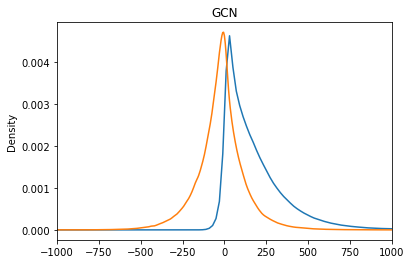

In [7]:
emb = np.load("../data/pokec_gcn_embs_fixed.npy")
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape, plot_dot_(A, P, N, model_name="GCN")

# GAT

100%|████████████████████████████| 1632803/1632803 [00:01<00:00, 934186.81it/s]


((1632803, 128), (1632803, 128), (1632803, 128), None)

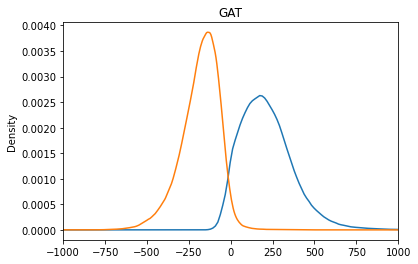

In [8]:
emb = np.load("../data/pokec_gat_embs_fixed.npy")
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape, plot_dot_(A, P, N, model_name="GAT")

In [9]:
# from utils.graph_utils import get_edges_faiss
# edges = get_edges_faiss(A)

In [10]:
# # create edge_list
# k, batch_size = 5, 2000
# from utils.graph_utils import get_edges_faiss
# edges = get_edges_faiss(a, k, batch_size,)
# edges

In [11]:
# # res = faiss.StandardGpuResources()
# index = faiss.IndexFlatIP(128)

In [12]:
# emb = a.copy()

In [13]:
# n_nodes, embedding_size = emb.shape
# train_sample_size = np.minimum(100000, n_nodes)
# nlist = int(np.ceil(np.sqrt(train_sample_size)))
# metric = faiss.METRIC_INNER_PRODUCT
# index = faiss.IndexIVFFlat(index, embedding_size, nlist, (metric))

In [14]:
from models.fast_knn import FastkNN
from utils.config import GPU_ID

knn = FastkNN(k=5, metric="cosine", exact=False,).fit(A, y.numpy())

In [15]:
knn.predict(A[:100, :], return_ids=True)

array([1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1.,
       1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0.,
       1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0.],
      dtype=float32)